<a href="https://colab.research.google.com/github/hyguo12/git-assignment/blob/main/VAE_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

We do something similar for the `Decoder` class, ensuring we reshape the output.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

FInally, we write an `Autoencoder` class that combines these two. Note that we could have easily written this entire autoencoder as a single neural network, but splitting them in two makes it conceptually clearer.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 77050416.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7186502.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43023723.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7984295.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



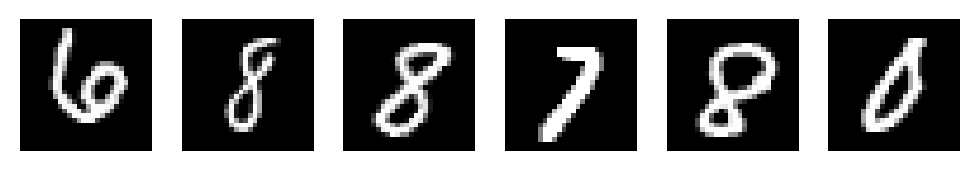

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_original_data(data_loader, num_samples=6):
    """
    Plot original data in a single row.

    Parameters:
        data_loader: torch.utils.data.DataLoader
            DataLoader containing the original data.
        num_samples: int, optional
            Number of samples to plot. Defaults to 6.
    """
    # Get a batch of data
    data_iter = iter(data_loader)
    images, _ = next(data_iter)

    # Initialize the plot
    plt.figure(figsize=(5, 1))

    # Plot each image in a single row
    for i in range(num_samples):
        # Extract the image and convert to numpy
        image = images[i].squeeze().numpy()

        # Plot the image
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:

plot_original_data(data)


In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train(autoencoder, data)

What should we look at once we've trained an autoencoder? I think that the following things are useful:

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [ ]:
autoencoder

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
import torch

# Assuming data is a DataLoader object
data_iterator = iter(data)
sample = next(data_iterator)

print("Input (x):", sample[0])
print("Label (y):", sample[1])


In [ ]:
sample[0][0].shape, sample[1][0]

(torch.Size([1, 28, 28]), tensor(2))

In [ ]:
sample[1]

tensor([2, 4, 1, 2, 0, 6, 5, 0, 9, 7, 8, 5, 3, 6, 4, 4, 3, 3, 1, 5, 2, 6, 2, 2,
        1, 9, 1, 8, 6, 1, 2, 8, 1, 2, 8, 3, 4, 9, 1, 9, 5, 9, 0, 2, 0, 8, 6, 8,
        2, 2, 3, 3, 4, 7, 1, 0, 4, 8, 1, 6, 6, 7, 6, 5, 5, 6, 3, 0, 9, 4, 0, 0,
        1, 6, 1, 6, 1, 3, 7, 9, 6, 3, 3, 2, 6, 6, 5, 7, 3, 2, 7, 5, 7, 1, 3, 2,
        6, 4, 8, 5, 2, 4, 2, 1, 8, 0, 2, 9, 0, 6, 5, 8, 3, 4, 5, 6, 8, 3, 8, 1,
        7, 1, 1, 7, 7, 4, 4, 5])

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10',s=1)
        if i > num_batches:
            plt.colorbar()
            break

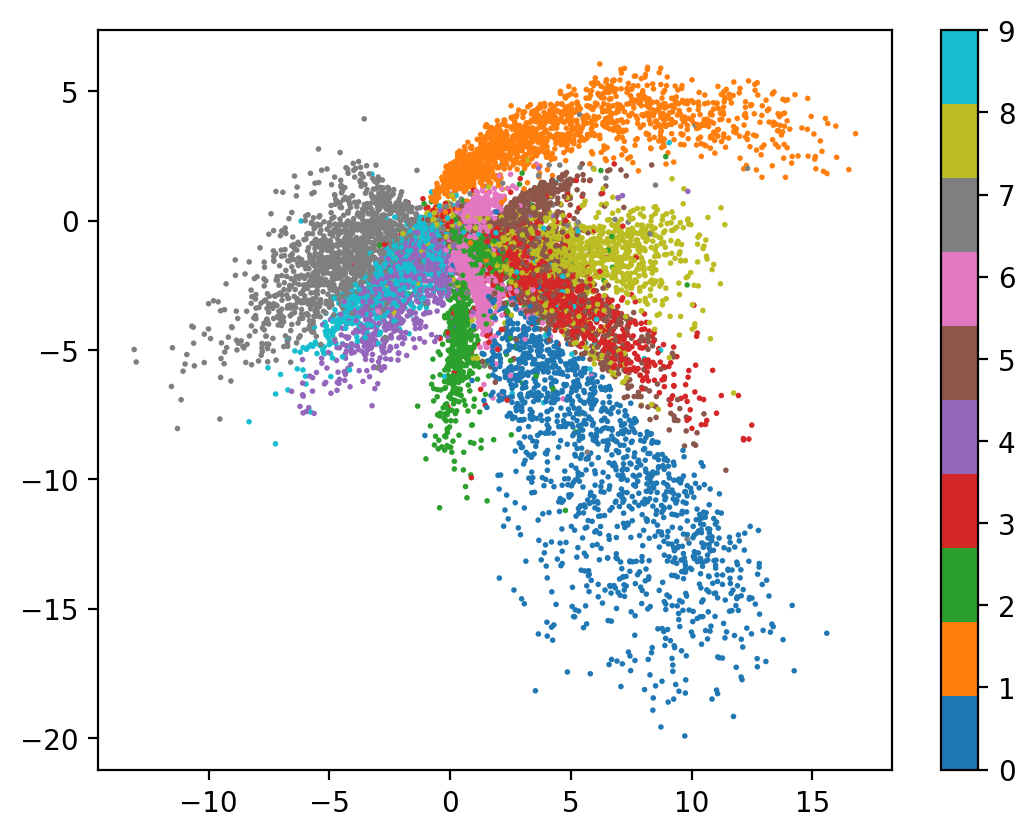

In [ ]:
plot_latent(autoencoder, data)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

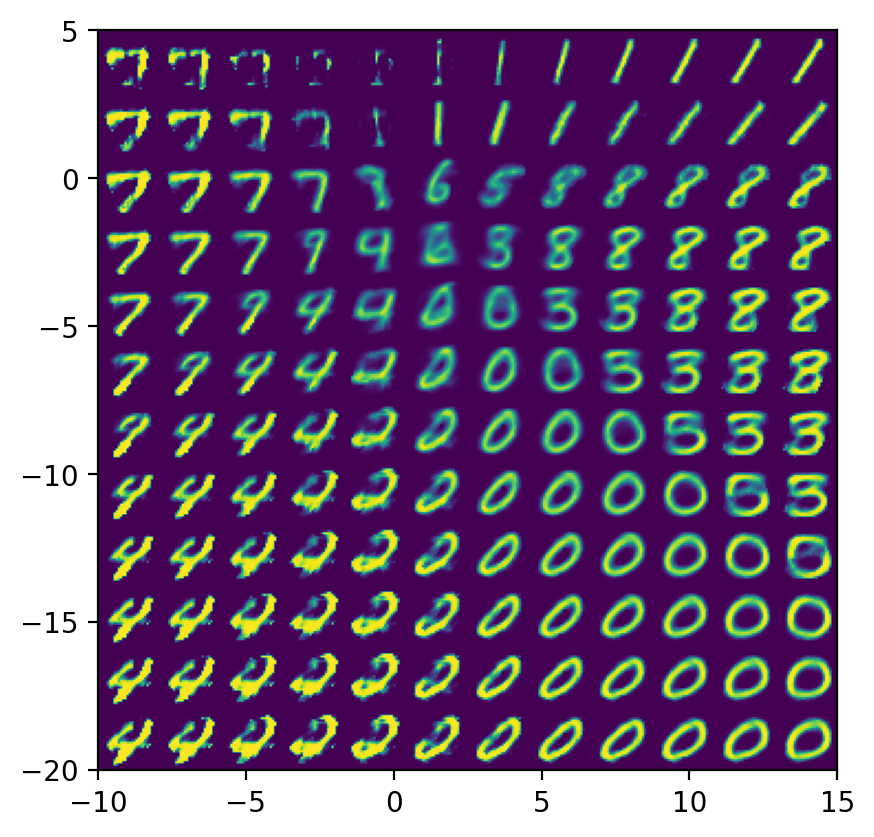

In [ ]:
plot_reconstructed(autoencoder)

We intentionally plot the reconstructed latent vectors using approximately the same range of values taken on by the actual latent vectors. We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space.

# Variational Autoencoders

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous. Variational autoencoders try to solve this problem.

In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result.

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

![variational autoencoder](variational-autoencoder.png)

However, this does not completely solve the problem. There may still be gaps in the latent space because the outputted means may be significantly different and the standard deviations may be small. To reduce that, we add an **auxillary loss** that penalizes the distribution $p(z \mid x)$ for being too far from the standard normal distribution $\mathcal{N}(0, 1)$. This penalty term is the KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, which is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \sigma^2 + \mu^2 - \log \sigma - \frac{1}{2} \right)
$$

This expression applies to two univariate Gaussian distributions (the full expression for two arbitrary univariate Gaussians is derived in [this math.stackexchange post](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)). Extending it to our diagonal Gaussian distributions is not difficult; we simply sum the KL divergence for each dimension.

This loss is useful for two reasons. First, we cannot train the encoder network by gradient descent without it, since gradients cannot flow through sampling (which is a non-differentiable operation). Second, by penalizing the KL divergence in this manner, we can encourage the latent vectors to occupy a more centralized and uniform location. In essence, we force the encoder to find latent vectors that approximately follow a standard Gaussian distribution that the decoder can then effectively decode.

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`.

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [ ]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

Let's plot the latent vector representations of a few batches of data.

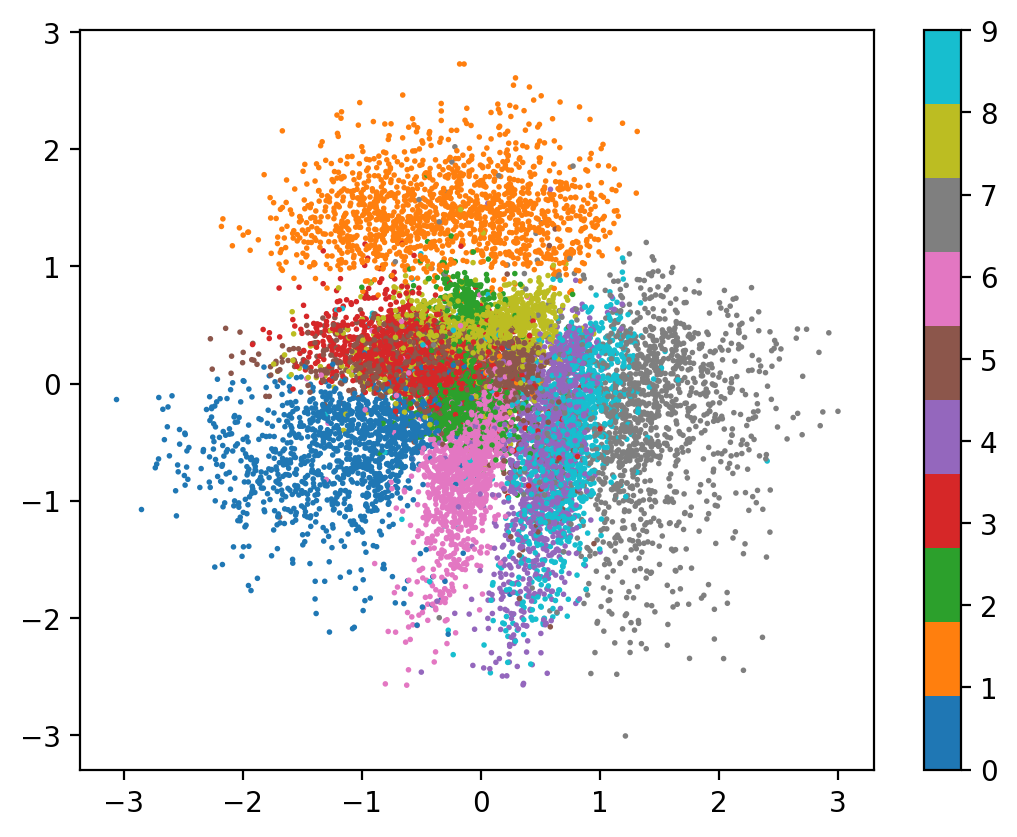

In [ ]:
plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

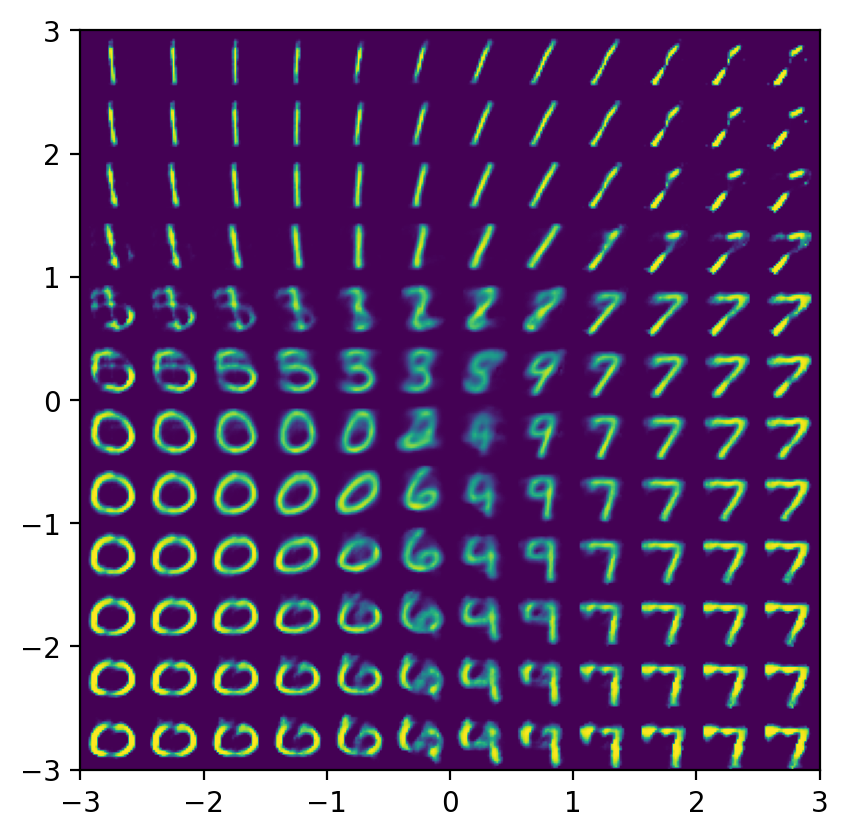

In [ ]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Conclusions

Variational autoencoders produce a latent space $Z$ that is more compact and smooth than that learned by traditional autoencoders. This lets us randomly sample points $z \sim Z$ and produce corresponding reconstructions $\hat{x} = d(z)$ that form realistic digits, unlike traditional autoencoders.

This post is inspired by these articles:
- [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)